In [1]:
import pandas as pd
import pickle 

# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_model_on_k_fold_validation import load_configuration

Training and Hyper-parameter tuning with Ray is not possible


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load 'args' from a trial id

In [2]:
trial_id = 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032'


# 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032' # STAEformer + Stack Channel + 500 epochs
# ' subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_03_04_19_34322' # STGformer w/o calendar + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_20_06_76371 ' ASTGCN + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_02_26_61597' ASTGCN + Stack Channel + 100 epochs
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn /
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn / No Temporal Attn
# "subway_in_netmob_POIs_per_station_STGCN_MSELoss_2025_02_18_03_38_83510" # NEW RIM ARCHITECTURE
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_14_16_03_71730' # NEW RIM ARCHITECTURE


# "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_02_01_12_25_68609"   #  Bug ????

# "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963"
# 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_05_04_80480'
# "subway_in_STGCN_MSELoss_2025_01_06_08_00_94523"
args,_ = load_configuration(trial_id,load_config=True)

print('Best args: ')
print(args)


>>>> Load best CONFIG
Best args: 
Namespace(model_name='STAEformer', dataset_names=['subway_in', 'subway_out', 'calendar'], dataset_for_coverage=['subway_in', 'netmob_POIs'], calendar_types=['dayofweek', 'timeofday'], embedding_calendar_types=['dayofweek', 'hour'], device=device(type='cuda'), optimizer='adamw', single_station=False, loss_function_type='MSE', epsilon_clustering=0.05, freq='15min', minmaxnorm=True, standardize=False, learnable_adj_matrix=False, learnable_adj_top_k=8, learnable_adj_embd_dim=8, contextual_positions={'calendar_dayofweek': 0, 'calendar_timeofday': 1, 'subway_out': 2}, quick_vision=False, netmob_transfer_mode='DL', evaluate_complete_ds=True, train_valid_test_split_method='similar_length_method', set_spatial_units=None, hp_tuning_on_first_fold=True, keep_best_weights=False, num_workers=0, persistent_workers=False, pin_memory=True, prefetch_factor=2, drop_last=False, mixed_precision=True, non_blocking=True, torch_compile=False, backend='inductor', prefetch_all

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split



def plot_distrib(df,variables,nb_columns=6):
    # 3. Analyse de corrélation univariée
    corr = df.corr()['Loss_model'].drop('Loss_model').sort_values()

    nb_rows = 1+ (len(variables)-1)//nb_columns
    fig, axes = plt.subplots(nb_rows, nb_columns, figsize=(25, 5*nb_rows))
    # 4. Visualisations scatter pour lr, weight_decay, dropout
    for i,param in enumerate(variables):
        n,p = divmod(i, nb_columns)
        if nb_rows > 1:
            axes[n][p].scatter(df[param], df['Loss_model'], alpha=0.5)
            axes[n][p].set_xlabel(param)
            axes[n][p].set_ylabel('Loss_model')
            axes[n][p].set_title(f'{param} vs Loss_model')
        else:
            # If only one row, use a single axis
            axes[p].scatter(df[param], df['Loss_model'], alpha=0.5)
            axes[p].set_xlabel(param)
            axes[p].set_ylabel('Loss_model')
            axes[p].set_title(f'{param} vs Loss_model')

    # 5. Importance via RandomForestRegressor
    X = df.drop(['training_iteration', 'Loss_model'], axis=1)
    X_enc = pd.get_dummies(X, drop_first=True)
    y = df['Loss_model']

    X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    importances = pd.Series(rf.feature_importances_, index=X_enc.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    importances.plot(kind='bar')
    plt.xlabel('Hyperparamètre')
    plt.ylabel('Importance')
    plt.title('Importance des hyperparamètres pour prédire la Loss_model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def PCA_df(df):
    # 1. Préparation des données
    # --------------------------
    # On part de df_all, déjà chargé
    # Sélection des colonnes d’entrée (on retire training_iteration et Loss_model)
    X = df.drop(columns=['training_iteration', 'Loss_model'])

    # Encodage des booléens / catégories
    X_enc = pd.get_dummies(X, drop_first=True)

    # Standardisation (très important pour la PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_enc)

    # 2. Ajustement de la PCA
    # ------------------------
    # On conserve autant de composantes que de variables, mais on regardera surtout les premières
    pca = PCA(n_components=X_scaled.shape[1], random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # 3. Analyse de la variance expliquée
    # -----------------------------------
    explained_ratio = pca.explained_variance_ratio_
    cum_explained = np.cumsum(explained_ratio)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(np.arange(1, len(explained_ratio)+1), cum_explained, marker='o')
    axes[0].set_xlabel('Nombre de composantes principales')
    axes[0].set_ylabel('Variance cumulée expliquée')
    axes[0].set_title('Courbe de variance expliquée par la PCA')
    axes[0].grid(True)
    #plt.show()

    # Affichage des variance par composante
    for i, (var, cum) in enumerate(zip(explained_ratio, cum_explained), start=1):
        print(f"PC{i}: {var:.3f} ; cumulée {cum:.3f}")

    # 4. Projection des données sur les deux premières composantes
    # ------------------------------------------------------------
    # On colorie par Loss_model (échelle de couleurs)
    sc = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                    c=df['Loss_model'], cmap='viridis', alpha=0.7)
    plt.colorbar(sc, label='Loss_model')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].set_title('Projection des runs sur PC1 vs PC2\ncolorié par Loss_model')
    axes[1].grid(True)

    # 5. Interprétation des composantes (loadings)
    # --------------------------------------------
    loadings = pd.DataFrame(pca.components_.T,
                            index=X_enc.columns,
                            columns=[f'PC{i}' for i in range(1, X_enc.shape[1]+1)])

    # On regarde surtout les loadings pour PC1 et PC2
    print("Loadings pour PC1 (variables les plus contributives) :")
    print(loadings['PC1'].abs().sort_values(ascending=False).head(10))
    print("\nLoadings pour PC2 (variables les plus contributives) :")
    print(loadings['PC2'].abs().sort_values(ascending=False).head(10))

    # Optionnel : biplot simplifié
    axes[2].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4)
    for var in loadings.index[:10]:  # on n’affiche que les 10 premières variables
        axes[2].arrow(0, 0,
                loadings.loc[var, 'PC1'] * 5,  # facteur d’échelle pour la visibilité
                loadings.loc[var, 'PC2'] * 5,
                color='red', alpha=0.7)
        axes[2].text(loadings.loc[var, 'PC1'] * 5.2,
                loadings.loc[var, 'PC2'] * 5.2,
                var, color='red', fontsize=8)
    axes[2].set_xlabel('PC1')
    axes[2].set_ylabel('PC2')
    axes[2].set_title('Biplot simplifié (10 variables les plus actives)')
    axes[2].grid(True)
    plt.show()

PC1: 0.215 ; cumulée 0.215
PC2: 0.119 ; cumulée 0.334
PC3: 0.113 ; cumulée 0.447
PC4: 0.105 ; cumulée 0.552
PC5: 0.096 ; cumulée 0.648
PC6: 0.084 ; cumulée 0.732
PC7: 0.071 ; cumulée 0.803
PC8: 0.058 ; cumulée 0.860
PC9: 0.054 ; cumulée 0.914
PC10: 0.049 ; cumulée 0.963
PC11: 0.037 ; cumulée 1.000
Loadings pour PC1 (variables les plus contributives) :
num_layers                         0.487997
torch_scheduler_milestone          0.416304
adaptive_embedding_dim             0.393352
input_embedding_dim                0.296315
torch_scheduler_lr_start_factor    0.289857
feed_forward_dim                   0.273833
dropout                            0.256665
torch_scheduler_gamma              0.227794
num_heads                          0.189943
lr                                 0.169966
Name: PC1, dtype: float64

Loadings pour PC2 (variables les plus contributives) :
torch_scheduler_lr_start_factor    0.502573
num_heads                          0.372321
feed_forward_dim                   0

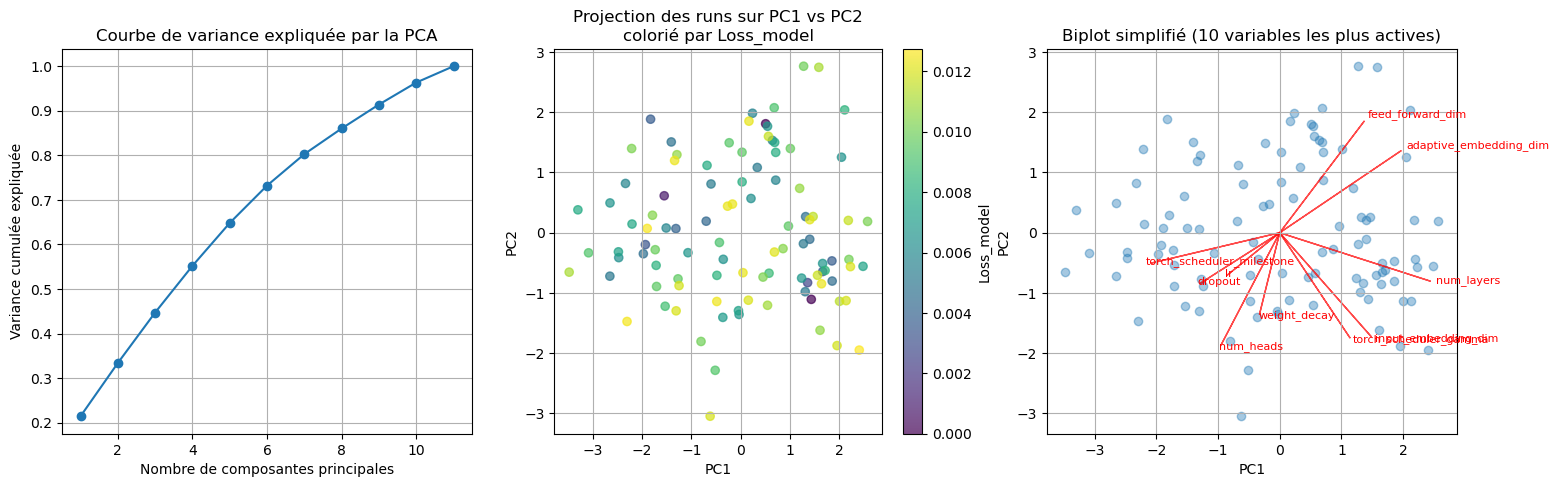

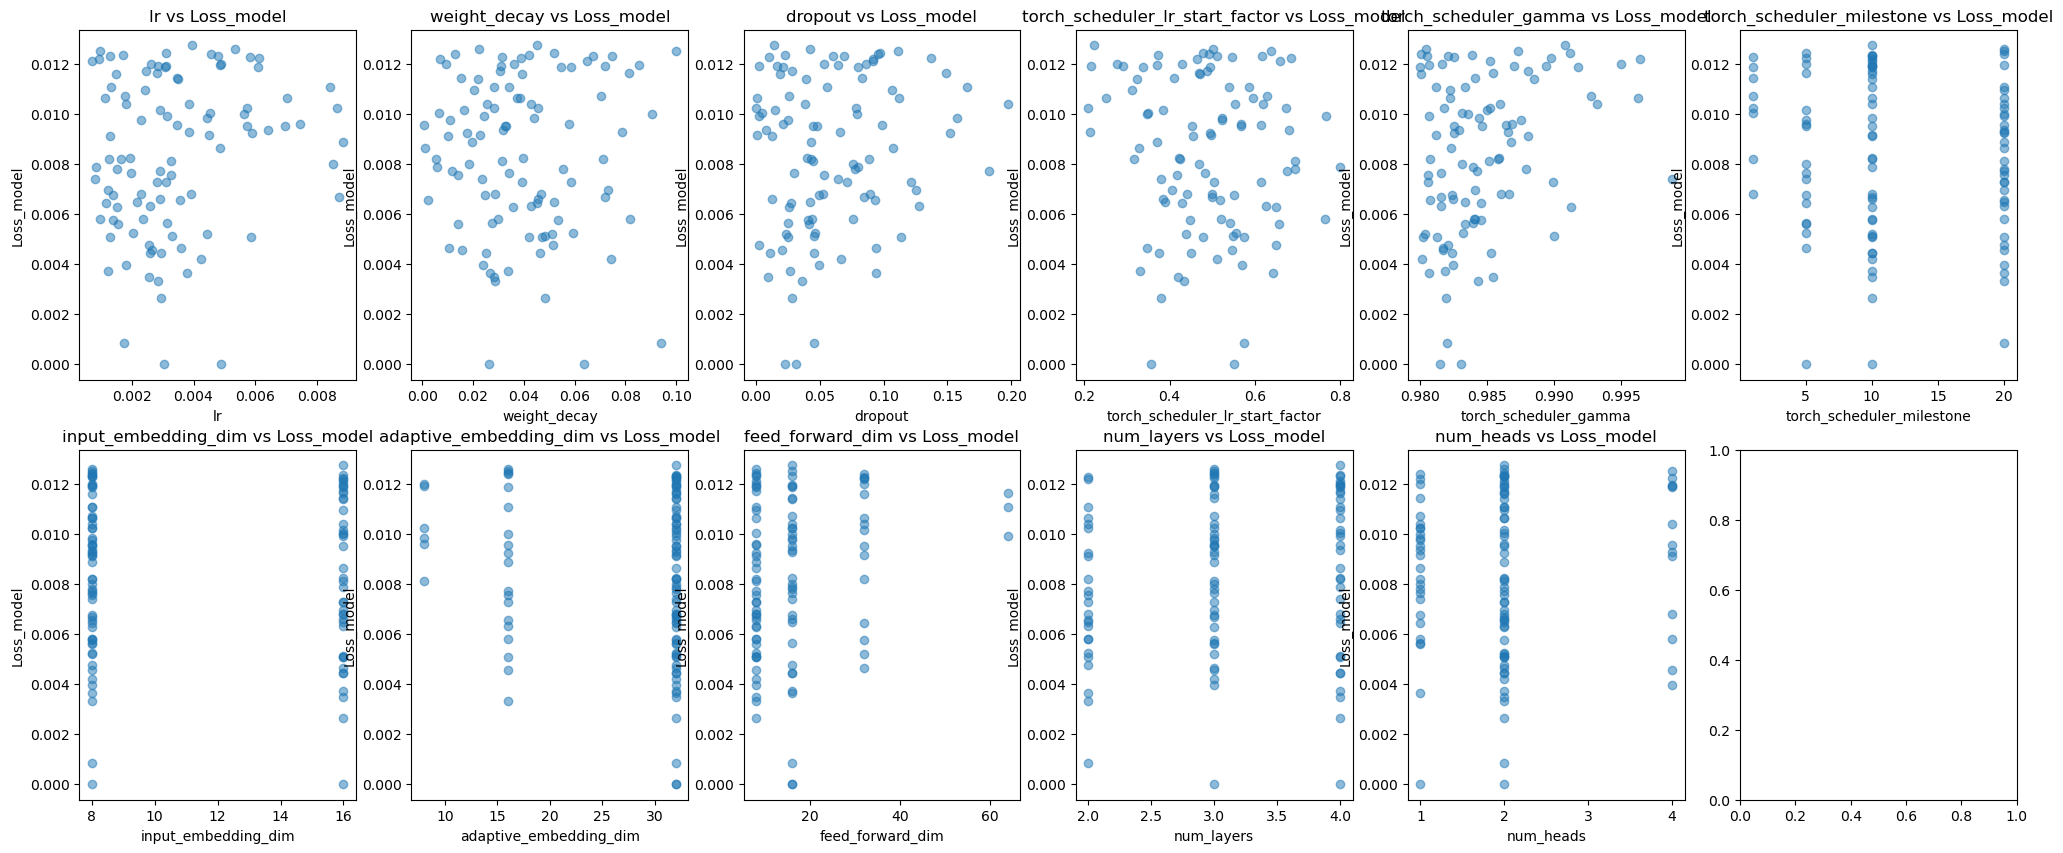

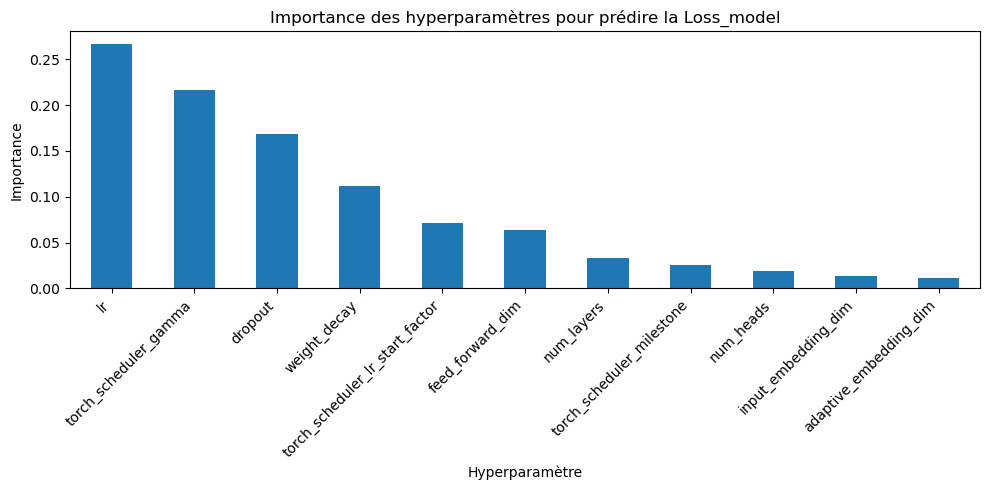

In [116]:
trial_id = 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032'
df_all = pd.DataFrame()

# HP tuning avec HyperOpt, 200 trials, et search space réduit
if True:
    trial_ids = ['subway_in_calendar_STAEformer_MSELoss_2025_05_15_10_08_21638',
                 'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_15_04_22_5433']

# HP tuning avec BasicVariant 500 epochs 
if False:
    trial_ids = ['subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_09_19_28_36371',
    'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_07_36_27059',
    'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752',
    'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_07_23_58546',
    'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_17_51_55895',
    'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_12_04_10_74908']

if False:
    trial_ids = ['subway_in_STGCN_MSELoss_2025_05_13_03_09_7326',
    'subway_in_calendar_embedding_STGCN_MSELoss_2025_05_13_22_43_80647'
    ]


for trial_id in trial_ids:

# 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032' # STAEformer + Stack Channel + 500 epochs
# ' subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_03_04_19_34322' # STGformer w/o calendar + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_20_06_76371 ' ASTGCN + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_02_26_61597' ASTGCN + Stack Channel + 100 epochs
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn /
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn / No Temporal Attn
# "subway_in_netmob_POIs_per_station_STGCN_MSELoss_2025_02_18_03_38_83510" # NEW RIM ARCHITECTURE
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_14_16_03_71730' # NEW RIM ARCHITECTURE

    df_hp_tuning =pd.read_csv(f'{os.getcwd()}/save/HyperparameterTuning/{trial_id}.csv')
    model_args = pickle.load(open(f'{os.getcwd()}/save/HyperparameterTuning/model_args.pkl','rb'))
    metric = '_metric/Loss_model'
    # Load common args through all tuning trials:
    args = model_args['model'][trial_id]['args']

    # Rename columns, remove useless ones: 
    columns = [c for c in df_hp_tuning.columns if ('_metric/' in c) or ('config/' in c) or ('training_iteration' in c)]
    columns_rename = {c:c.split('/')[-1] for c in columns}
    df_best_configs = df_hp_tuning[columns].sort_values(metric).rename(columns = columns_rename)
    df_best_configs
    
    #print('Best configs:')
    #display(df_best_configs.iloc[:20])

    nb_best_configs = 100

    # Normalize the Loss:
    df_best_configs['Loss_model'] = (df_best_configs.Loss_model-df_best_configs.Loss_model.min())/(df_best_configs.Loss_model.max()-df_best_configs.Loss_model.min())
    df_all = pd.concat([df_all,df_best_configs.iloc[:nb_best_configs]])

    columns_to_drop = []
    variable_to_analyse = ['lr', 'weight_decay', 'dropout','torch_scheduler_lr_start_factor','torch_scheduler_gamma','torch_scheduler_milestone',
                            'input_embedding_dim','adaptive_embedding_dim', 'feed_forward_dim','num_layers', 'num_heads',]
    columns = [c for c in df_all.columns if not c in columns_to_drop]
    #PCA_df(df_best_configs[:nb_best_configs][columns])
    #plot_distrib(df_best_configs[:nb_best_configs],variable_to_analyse)
    #break


df_all.sort_values('Loss_model',inplace=True)
PCA_df(df_all[:nb_best_configs][columns])
plot_distrib(df_all[:nb_best_configs],variable_to_analyse)

if False:
    import matplotlib.pyplot as plt
    for c in df_all.columns:
        plt.title(c)
        df_all[c].astype(float).hist()
        plt.show()

<Axes: >

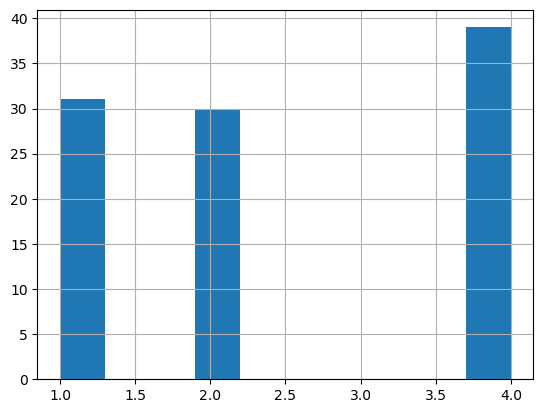

In [114]:
df_all['num_heads'].iloc[:100].hist()

In [79]:
df_all

,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
232,500,0.000000,0.00406,0.055260,0.103913,8,32,4,3,32,True,7,0.986538,0.604592
245,500,0.000368,0.00136,0.061312,0.043653,16,32,2,5,8,False,10,0.992713,0.368402
161,500,0.000446,0.00152,0.081419,0.121549,24,12,1,4,16,True,4,0.994398,0.274702
493,500,0.000546,0.00946,0.094140,0.139241,16,12,4,3,256,True,3,0.987031,0.358074
371,500,0.000605,0.00292,0.092190,0.111715,8,16,1,3,32,True,17,0.985703,0.632893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,160,0.003080,0.00239,0.013088,0.161513,16,8,1,1,32,False,6,0.994072,0.443115
285,80,0.003185,0.00615,0.072515,0.057130,24,8,4,1,8,True,14,0.986950,0.527789
336,80,0.003226,0.00332,0.062767,0.044021,16,12,4,1,32,False,4,0.998730,0.129269
391,80,0.003249,0.00201,0.037573,0.086840,16,16,2,3,256,True,11,0.998640,0.956085


In [78]:
df_best_configs

,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
232,500,0.000000,0.00406,0.055260,0.103913,8,32,4,3,32,True,7,0.986538,0.604592
245,500,0.000368,0.00136,0.061312,0.043653,16,32,2,5,8,False,10,0.992713,0.368402
161,500,0.000446,0.00152,0.081419,0.121549,24,12,1,4,16,True,4,0.994398,0.274702
493,500,0.000546,0.00946,0.094140,0.139241,16,12,4,3,256,True,3,0.987031,0.358074
371,500,0.000605,0.00292,0.092190,0.111715,8,16,1,3,32,True,17,0.985703,0.632893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,20,0.559976,0.00005,0.053746,0.118997,16,12,2,2,32,False,19,0.995666,0.415225
390,20,0.604028,0.00003,0.086796,0.048052,24,12,4,3,128,False,14,0.997070,0.159764
452,20,0.704851,0.00001,0.091406,0.126884,24,8,1,3,256,False,7,0.996198,0.212466
326,20,0.713031,0.00004,0.066507,0.062054,8,8,4,3,64,False,6,0.988287,0.485421


Get the configuration: 

In [16]:
for c in df_best_configs.columns:
    v = df_best_configs.iloc[0,:][c]
    print(f"'{c}': {v}")

'training_iteration': 100
'Loss_model': 0.0031529362496546
'lr': 0.00105
'weight_decay': 0.0188896655584368
'dropout': 0.271795372610271
'Kt': 2
'stblock_num': 3
'gso_type': sym_renorm_adj
'temporal_h_dim': 256
'spatial_h_dim': 32
'output_h_dim': 16
'scheduler': True
'torch_scheduler_milestone': 28.0
'torch_scheduler_gamma': 0.9958348861339396
'torch_scheduler_lr_start_factor': 0.8809942312067847


In [ ]:
df = df_best_configs[~df_best_configs.scheduler.isna()]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['lr'], df['weight_decay'], df['dropout'], 
                     c=df['Loss_model'], cmap='YlOrRd_r', s=50)

ax.set_xlabel('lr')
ax.set_ylabel('weight_decay')
ax.set_zlabel('dropout')
ax.set_title("Loss function of weight-decay, dropout and lr")
ax.view_init(30, 60, 0)
fig.colorbar(scatter, ax=ax, label='Loss_model')
plt.show()

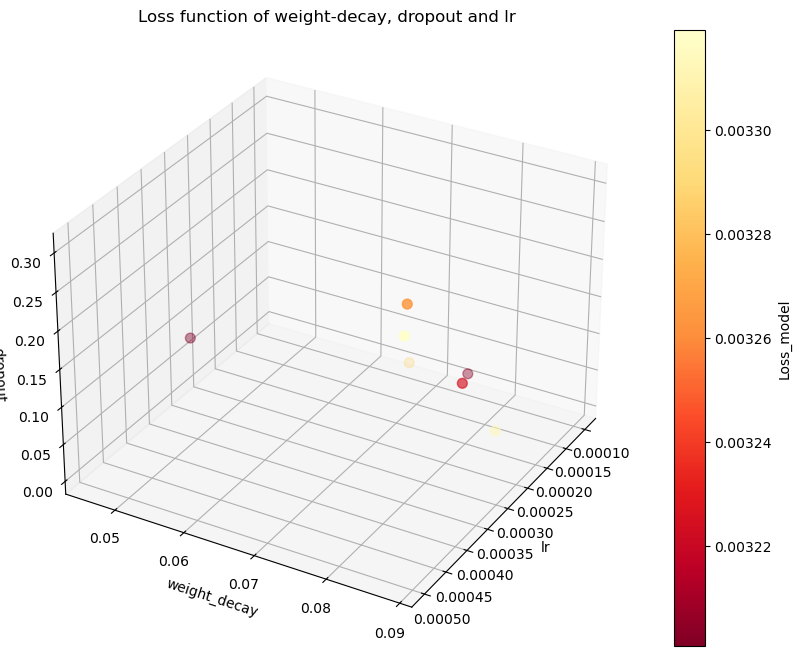

In [33]:


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plotting_loss_function_of_w_d_lr(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df['lr'], df['weight_decay'], df['dropout'], 
                        c=df['Loss_model'], cmap='YlOrRd_r', s=50)

    ax.set_xlabel('lr')
    ax.set_ylabel('weight_decay')
    ax.set_zlabel('dropout')
    ax.set_title("Loss function of weight-decay, dropout and lr")
    ax.view_init(30, 30, 0)
    fig.colorbar(scatter, ax=ax, label='Loss_model')
    plt.show()


max_loss = 0.00332
max_lr =1 #0.003
df_filtered = df_best_configs[(df_best_configs['Loss_model'] < max_loss) &
                              (df_best_configs['lr'] < max_lr)]

df = df_filtered[~df_filtered.scheduler.isna()]
plotting_loss_function_of_w_d_lr(df)


#df = df_filtered[df_filtered.scheduler.isna()]
#plotting_loss_function_of_w_d_lr(df)


#plotting_loss_function_of_w_d_lr(df_filtered)

In [4]:
df_hp_tuning =pd.read_csv(f'save/HyperparameterTuning/{trial_id}.csv')
model_args = pickle.load(open(f'save/HyperparameterTuning/model_args.pkl','rb'))
metric = '_metric/Loss_model'
# Load common args through all tuning trials:
args = model_args['model'][trial_id]['args']

# Rename columns, remove useless ones: 
columns = [c for c in df_hp_tuning.columns if ('_metric/' in c) or ('config/' in c)]
columns_rename = {c:c.split('/')[-1] for c in columns}
df_best_configs = df_hp_tuning[columns].sort_values(metric).rename(columns = columns_rename)
df_best_configs
print('Best configs:')
display(df_best_configs.iloc[:20])

Best configs:


,Loss_model,lr,weight_decay,dropout,temporal_h_dim,spatial_h_dim,output_h_dim,TGE_num_layers,TGE_num_heads,TGE_FC_hdim,scheduler,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
43,0.003555,0.00145,0.093438,0.017829,128,32,64,3,1,8,True,29.0,0.988059,0.600637
180,0.003558,0.00290,0.056935,0.205239,8,128,32,8,2,16,True,16.0,0.994082,0.494039
415,0.003686,0.00310,0.076135,0.209686,128,32,16,4,1,64,True,6.0,0.989726,0.609100
479,0.003715,0.00260,0.015236,0.153810,64,16,256,8,8,16,True,21.0,0.986840,0.273233
72,0.003723,0.00265,0.056675,0.087503,64,128,64,1,1,8,True,13.0,0.987510,0.355194
488,0.003726,0.00030,0.035155,0.013960,32,32,256,1,1,256,NaN,NaN,NaN,NaN
234,0.003740,0.00060,0.082800,0.119636,32,256,256,2,8,16,True,14.0,0.991411,0.928782
262,0.003776,0.00125,0.061103,0.065937,16,64,32,3,8,64,True,13.0,0.989121,0.202832
247,0.003781,0.00245,0.054753,0.018427,32,128,8,4,1,64,NaN,NaN,NaN,NaN
57,0.003792,0.00015,0.068777,0.034193,128,8,256,8,2,256,True,6.0,0.996067,0.284229


## Load best configs from a trial id:

In [3]:
df_hp_tuning =pd.read_csv(f'save/HyperparameterTuning/{trial_id}.csv')
model_args = pickle.load(open(f'save/HyperparameterTuning/model_args.pkl','rb'))
metric = '_metric/Loss_model'
# Load common args through all tuning trials:
args = model_args['model'][trial_id]['args']

# Rename columns, remove useless ones: 
columns = [c for c in df_hp_tuning.columns if ('_metric/' in c) or ('config/' in c)]
columns_rename = {c:c.split('/')[-1] for c in columns}
df_best_configs = df_hp_tuning[columns].sort_values(metric).rename(columns = columns_rename)
df_best_configs
print('Best configs:')
display(df_best_configs.iloc[:20])

Best configs:


,Loss_model,lr,weight_decay,dropout,temporal_h_dim,spatial_h_dim,output_h_dim,scheduler,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor,concatenation_early,concatenation_late,num_heads,grn_out_dim
351,0.005105,0.00065,0.007052,0.278061,256,256,8,True,25.0,0.991593,0.752912,True,False,2,64
226,0.005124,0.00115,0.065237,0.159976,16,8,8,NaN,NaN,NaN,NaN,True,True,4,32
414,0.005195,0.00055,0.024583,0.134271,32,256,16,NaN,NaN,NaN,NaN,True,True,4,16
316,0.005217,0.00110,0.022065,0.100491,256,64,32,True,28.0,0.995704,0.542937,True,True,1,16
353,0.005256,0.00400,0.072955,0.068490,32,8,8,NaN,NaN,NaN,NaN,True,False,3,24
358,0.005258,0.00260,0.017781,0.522119,16,8,256,NaN,NaN,NaN,NaN,True,False,1,8
255,0.005270,0.00055,0.065677,0.287299,256,256,128,NaN,NaN,NaN,NaN,True,False,2,8
272,0.005285,0.00485,0.015913,0.078816,64,64,256,True,2.0,0.998806,0.508260,True,False,2,32
286,0.005343,0.00070,0.033701,0.385530,256,64,128,True,7.0,0.990168,0.132749,True,True,6,48
341,0.005344,0.00390,0.037983,0.313570,128,16,32,NaN,NaN,NaN,NaN,True,True,3,24


## Load `the` best config, with no rename: 

In [8]:
# Get best config :
best_model = df_hp_tuning.sort_values(metric).iloc[0]
print('raw config of best model: ')
display(best_model)

raw config of best model: 


trial_id                                                                                       b9f67_00351
time_this_iter_s                                                                                  4.243078
done                                                                                                  True
training_iteration                                                                                     100
date                                                                                   2025-01-07_01-20-56
timestamp                                                                                       1736209256
time_total_s                                                                                    442.195914
pid                                                                                                 144430
hostname                                                                                 ticil2.ifsttar.fr
node_ip                              